In [ ]:
# imports
import os
import tifffile as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB # Bayesian Classifier implementation
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
import seaborn as sns

In [2]:
CLASS_NAMES = [
    "OpenWater",
    "Leads withWater",
    "Brash/Pancake Ice",
    "Thin Ice",
    "Thick Ice-Flat",
    "Thick Ice-Ridged"
]

PATCHES_FOLDER = "Patches32x32\\32"
CHANNEL_INDEX = 1  # HH is the first channel (index 0), but we can also take HV (index 1)

# Data Preparation

In [3]:
def load_and_extract_patches(channel_index):
    patches = []
    labels = []
    
    # 1. Iterate through all files in the directory
    for class_index in range(len(CLASS_NAMES)):
        class_dir = os.path.join(PATCHES_FOLDER, str(class_index))
        patch_files = glob.glob(os.path.join(class_dir, '*')) 

        for filename in patch_files:
                try:
                    patch = tf.imread(filename)
                    
                    # Select all rows, all columns, and the specified channel index
                    patch = patch[..., channel_index]
                    
                    # Convert to a float format for calculation
                    patch = patch.astype(np.float64) 
                    
                    patches.append(patch)
                    labels.append(class_index)
                    print(f"Successfully loaded and extracted HH from: {filename} (Shape: {patch.shape})")

                except Exception as e:
                    print(f"Error reading {filename}: {e}")

    return patches, labels

patches, labels = load_and_extract_patches(CHANNEL_INDEX)

print(f"\nTotal patches loaded: {len(patches)}")

Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_0041236c-d936-4557-8479-023c94c89200.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_0048bc59-a637-47c1-9a0e-7abdc0557801.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_0065b39d-ffc7-42b5-a6c6-0a8e7fdbb10b.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_007a7de8-cd3f-49a9-8cb7-7cd3a358e2de.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_007d2790-cff8-4347-b22a-a0f3b2c36f23.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_009628df-3784-46af-b10f-99cfee5051f1.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_00d565fc-bb3f-4da0-878c-87dc928b10bd.tiff (Shape: (32, 32))
Successfully loaded and extracted HH from: Patches32x32\32\0\0_005365_010266cc-6b5b-4eef-9

Text(0.5, 1.0, 'Example Data - Sea Ice Patch')

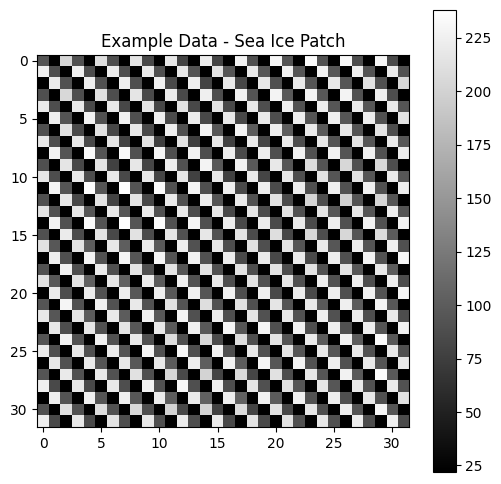

In [4]:
# Plot an example patch
fig, ax = plt.subplots(figsize=(6, 6))
img = ax.imshow(patches[0], cmap='gray')

# Add a color bar to show the intensity scale
plt.colorbar(img, ax=ax, orientation='vertical')
# plt.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

# Set title and labels
ax.set_title("Example Data - Sea Ice Patch")

# Method Implementation

Note: In the paper they are working with patches of size 64x64. This is why they have displacement range up to d=32. Since we are using a smaller patch size (32x32) we can only take maximum d=16.
Also, the library that we are using `graycoprops` has only 6 features available out of the features they used - which should be still sufficient.

I also minimized the uniform quantization levels as it gave a better result.

In [16]:
N_G = 32 # Uniform quantization levels
DISPLACEMENTS = np.arange(1, 9)
ORIENTATIONS  = [0, 45, 90, 135]
FEATURE_NAMES = ['energy', 'contrast', 'correlation', 'homogeneity', 'entropy', 'dissimilarity']


def quantize_image(patch: np.ndarray, n_levels: int) -> np.ndarray:
    """Applies uniform quantization"""
    min_val = patch.min()
    max_val = patch.max()
    
    if max_val == min_val:
        return np.full(patch.shape, 0, dtype=np.uint8)

    # Rescale the patch to the range [0, n_levels - 1]
    scaled_patch = ((patch - min_val) / (max_val - min_val)) * (n_levels)
    quantized_patch = np.clip(scaled_patch, 0, n_levels - 1).astype(np.uint8)
    
    return quantized_patch

def calculate_mdmo_features(patch: np.ndarray) -> np.ndarray:
    """
    Calculates the 8-feature MDMO vector by averaging over displacement and orientation.
    """
    # Quantize the patch
    quantized_patch = quantize_image(patch, N_G)
    
    # Check for minimum processing requirements (e.g., d=32 needs at least 33x33)
    if min(quantized_patch.shape) < max(DISPLACEMENTS) + 1:
        print(f"Error: Patch size {patch.shape} is too small for max displacement {max(DISPLACEMENTS)}.")
        return np.full(len(FEATURE_NAMES), np.nan) 
        
    total_feature_sums = np.zeros(len(FEATURE_NAMES))
    
    # Looping through Mean Displacement
    for d in DISPLACEMENTS:
        distance_tuple = (d,)
        
        # Compute GLCM for all 4 orientations at this displacement d
        # glcm shape: (N_G, N_G, 1, 4) -> 1 distance, 4 angles
        glcm = graycomatrix(
            quantized_patch, 
            distances=distance_tuple, 
            angles=ORIENTATIONS, 
            levels=N_G, 
            symmetric=True, 
            normed=True
        )

        mean_orientation_features = []
        
        # Mean Orientation (Averaging over theta)
        for feature_name in FEATURE_NAMES:
            # graycoprops returns an array of shape (1, 4) for this feature across the 4 angles
            props = graycoprops(glcm, feature_name)[0]
            
            # Perform the Mean Orientation averaging (np.mean on the 4 angle values)
            mean_feature_val = np.mean(props)
            mean_orientation_features.append(mean_feature_val)
        
        # Accumulate the Mean Orientation vector for the outer average
        total_feature_sums += np.array(mean_orientation_features)

    # Average over all displacement values (Mean Displacement)
    MDMO_FEATURE_VECTOR = total_feature_sums / len(DISPLACEMENTS)

    return MDMO_FEATURE_VECTOR

In [17]:
mdmo_data = []

# Process all loaded patches
print(f"Starting MDMO feature calculation for {len(patches)} patches...")
for i, patch in enumerate(patches):
    mdmo_vector = calculate_mdmo_features(patch)
    if not np.any(np.isnan(mdmo_vector)):
        mdmo_data.append(mdmo_vector)

# Final Feature Matrix
MDMO_FEATURE_MATRIX = np.vstack(mdmo_data)

print("\n--- MDMO Feature Matrix Created ---")
print(f"Shape (Samples x Features): {MDMO_FEATURE_MATRIX.shape}")

Starting MDMO feature calculation for 11200 patches...

--- MDMO Feature Matrix Created ---
Shape (Samples x Features): (11200, 6)


In [18]:
import pandas as pd 

# Create the pandas DataFrame for GLCM features data
glcm_df = pd.DataFrame(MDMO_FEATURE_MATRIX, 
                      columns = FEATURE_NAMES)

glcm_df.head(10)

,energy,contrast,correlation,homogeneity,entropy,dissimilarity
0,0.255628,297.220682,-0.030743,0.236703,3.286992,13.394431
1,0.232523,278.782516,-0.030110,0.227986,3.593688,13.101187
2,0.213815,274.742603,-0.029657,0.207801,3.895582,12.885429
3,0.247826,280.579480,-0.030495,0.240052,3.370793,13.156768
4,0.208993,248.681005,-0.029426,0.205830,3.979749,12.460110
5,0.195078,35.953619,0.048421,0.264198,4.562037,4.477193
6,0.197859,233.540877,-0.030903,0.187709,4.268454,12.062015
7,0.179830,117.580151,-0.017247,0.225103,4.772438,8.244065
8,0.205666,228.357005,-0.028102,0.252261,4.161555,11.079036
9,0.237194,287.285304,-0.030537,0.226833,3.508013,13.324273


Test Set Classification Accuracy: 0.5629
Cohen's Kappa (KHAT) Statistic: 0.3052


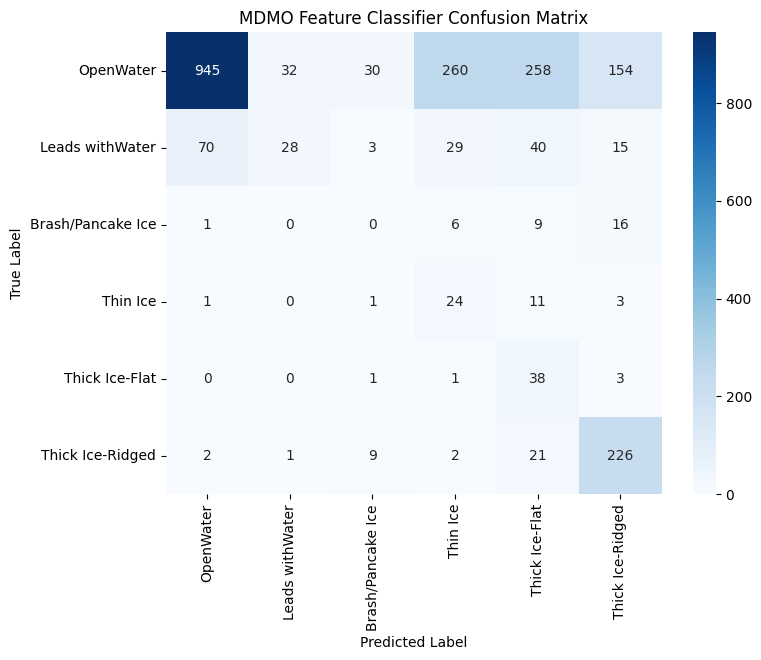

In [19]:
# In the paper they used 50/50 train-test split and Gaussian Naive Bayes classifier
# We are going to try different splits (maybe be classifiers as well)
X_train, X_test, y_train, y_test = train_test_split(
    MDMO_FEATURE_MATRIX, labels, test_size=0.20, random_state=42, stratify=labels
)

classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_test_pred = classifier.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred) # they used KHAT statistics (an estimate of KAPPA)
cm = confusion_matrix(y_test, y_test_pred)


print(f"Test Set Classification Accuracy: {test_accuracy:.4f}") #Goal: 94.17%
print(f"Cohen's Kappa (KHAT) Statistic: {test_kappa:.4f}") #Goal: >0.9

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('MDMO Feature Classifier Confusion Matrix')
plt.show()

In [ ]:
# Test Set Classification Accuracy: 0.5855 (Goal: 94.17%)
# Cohen's Kappa (KHAT) Statistic: 0.3187 (Goal: >0.9)